In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import matplotlib.patheffects
import matplotlib as mpl
import numpy as np
import pandas as pd
import vice

import surp

from surp._globals import AGB_MODELS
import arya
import scipy

from surp import yields
from surp.gce_math import Z_SUN, MH_to_Z, Z_to_MH

/users/PAS2232/aeyobd/VICE/vice/__init__.py:141: UserWarning: Using un-released version of VICE
  warnings.warn("Using un-released version of VICE", UserWarning)


In [3]:
def plot_c_table(study = "cristallo11", ele="c", ax=None, fig=None, factor=1e2, **kwargs):
    if ax is None:
        fig, ax = plt.subplots()

    y1, m1, z1 = vice.yields.agb.grid(ele, study=study)
    N = len(z1)

    for i in range(N):
        y = np.array(y1)[:,i] * factor
        z = z1[i] 
        c = hmap(np.log10(z/0.014))
        f = ax.plot(m1, y, "o", label=f"Z = {z}", c=(c), **kwargs)
        f = ax.plot(m1, y, label=f"Z = {z}", c=(c), **kwargs)
        # ax.set_xticks(np.arange(1, 8))
    
    ax.axhline(0, color="k", ls=":", zorder=-1)

    return f

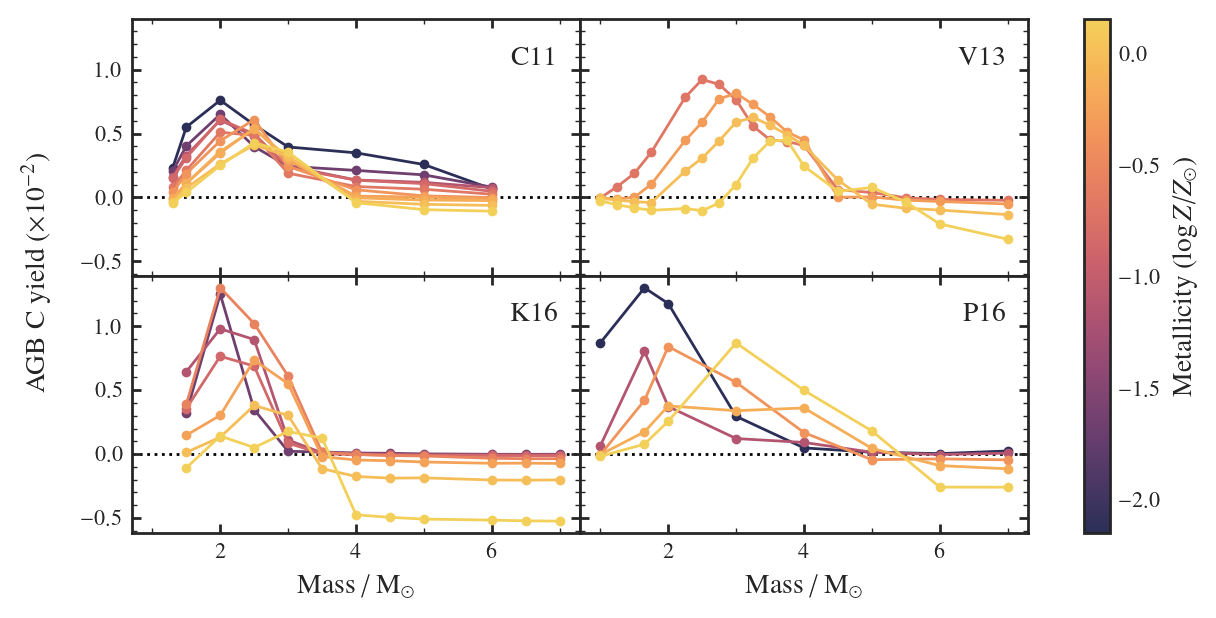

In [4]:
Z_max = 0.02
Z_min = 0.0001
AGB_LABELS = ["C11", "V13", "K16",  "P16"]

hmap = arya.figure.colorbar.HueMap((np.log10(Z_min/0.014), np.log10(Z_max/0.014)))




fig, axs = plt.subplots(2, 2, figsize=(7, 10/3), sharex=True, sharey=True, gridspec_kw={"hspace":0, "wspace": 0, "left": 0.1})
# plt.minorticks_off()

for i in range(4):
    study = ["cristallo11", "karakas16", "ventura13", "pignatari16"][i]
    label = AGB_LABELS[i]
    ax = axs[i//2][i%2]
    f = plot_c_table(study, ax=ax, fig=fig)
    
    ax.text(0.95, 0.9, label, horizontalalignment='right',
            verticalalignment='top', transform=ax.transAxes)
    

# axes.set_position([left, Botton, width height])
# .get_position to set colorbar
# TODO: split axes to fix range
arya.Colorbar(huemap=hmap, ax=axs.ravel().tolist(), label=r"Metallicity ($\log Z/Z_\odot$)")


plt.setp(axs[-1, :], xlabel=r'Mass / ${\rm M}_\odot$')
fig.supylabel(r"AGB C yield ($\times 10^{-2}$)")
plt.gca().xaxis.set_minor_locator(mpl.ticker.AutoMinorLocator(2))

plt.savefig("figures/agb_yields.pdf")

In [5]:
def calc_y(Z=Z_SUN, ele="c"):
    m_c, times = vice.single_stellar_population(ele, Z=Z, mstar=1)
    return m_c[-1]

In [6]:
def plot_y_z(Zs, ele="c", kind="line", factor = 1, **kwargs):
    mass_yields = []
    
    for Z in Zs:
        m_c, times = vice.single_stellar_population(ele, Z=Z)
        mass_yields.append(m_c[-1])
        
    y_c_agb = np.array(mass_yields)/1e6 * factor

    if kind == "line":
        plot = plt.plot
    elif kind == "scatter":
        plot = plt.scatter
        
    return plot(Z_to_MH(Zs), y_c_agb, **kwargs), y_c_agb

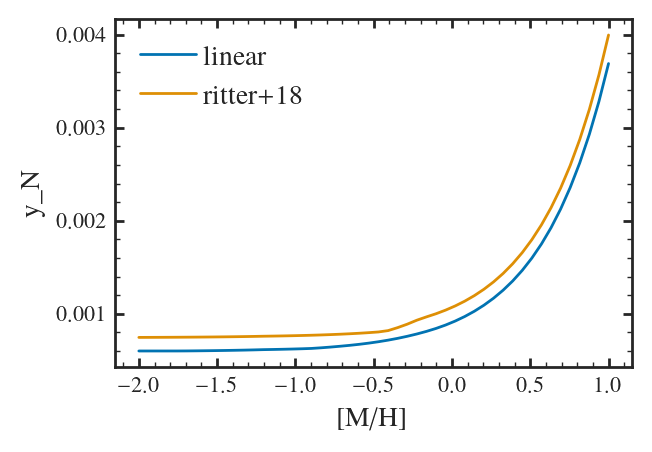

In [7]:
yields.set_defaults()

plot_y_z(MH_to_Z(np.linspace(-2, 1)), "n", label="linear");

vice.yields.agb.settings["n"] = "pignatari16"

plot_y_z(MH_to_Z(np.linspace(-2, 1)), "n", label="ritter+18");
plt.xlabel("[M/H]")
plt.ylabel("y_N")

plt.legend()
plt.savefig("figures/y_n_z.pdf")

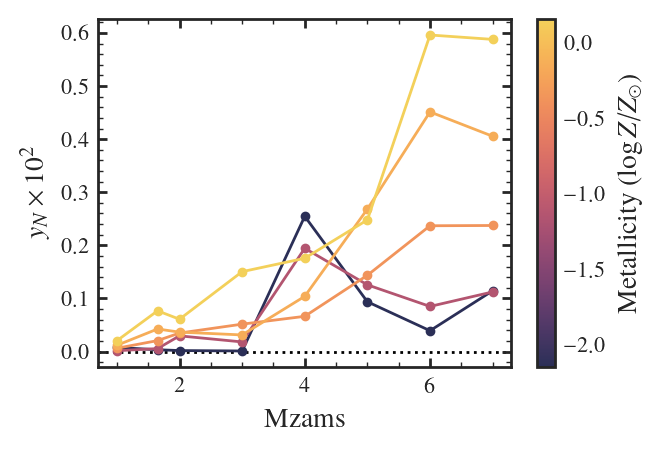

In [8]:
plot_c_table("pignatari16", "n")
plt.xlabel("Mzams")
plt.ylabel(r"$y_N \times 10^2$")
arya.Colorbar(huemap=hmap, label=r"Metallicity ($\log Z/Z_\odot$)")
plt.savefig("ritter18_n_table.pdf")

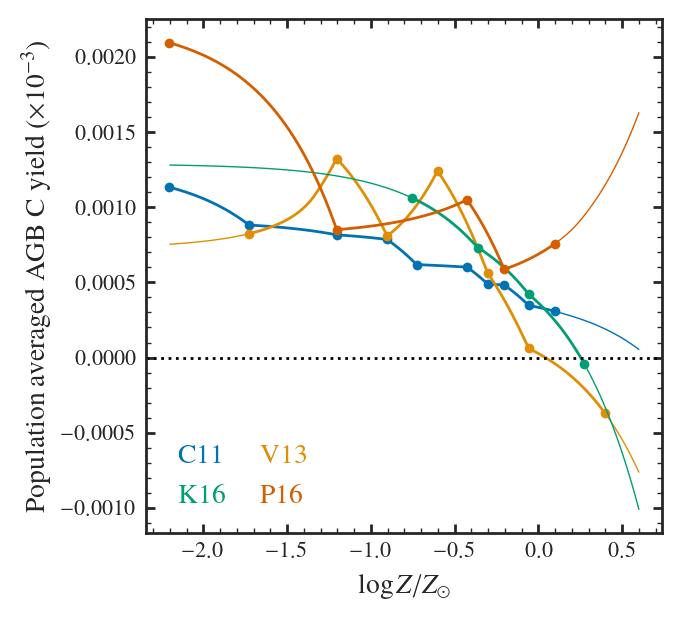

In [9]:
plt.figure(figsize=(10/3, 10/3))
x_min = -2.2
x_max = 0.6
N_points = 100

for i in range(4):
    model = AGB_MODELS[i]

    vice.yields.agb.settings["c"] = model
    vice.yields.ccsne.settings["c"] = 0
    
    # plots importaint points
    y1, m1, z1 = vice.yields.agb.grid('c', study=model)
    plot_y_z(z1, kind="scatter", zorder=i)
    
    # plot solid within range
    MoverH_min = Z_to_MH(min(z1))
    MoverH_max = Z_to_MH(max(z1))
    
    Zs = MH_to_Z(np.linspace(MoverH_min, MoverH_max, N_points))
    (line,), x = plot_y_z(Zs, label=AGB_LABELS[i], zorder=i)
    color = line.get_color()

    Zs = MH_to_Z(np.linspace(x_min, MoverH_min, N_points))    
    plot_y_z(Zs, lw=0.5, color=color, zorder=i)

    Zs = MH_to_Z(np.linspace(MoverH_max, x_max, N_points))
    plot_y_z(Zs, lw=0.5, color=color, zorder=i)


plt.axhline(0, color="k", ls=":")
plt.xlabel(r"$\log Z/Z_\odot$")
plt.ylabel(r"Population averaged AGB C yield ($\times 10^{-3}$)")

#plt.ylim(-0.001)
prop_cycle = plt.rcParams['axes.prop_cycle']

arya.Legend(color_only=True, handlelength=0, ncols=2, columnspacing=1, loc=3, transpose=True)


plt.savefig("figures/y_agb_vs_z.pdf")

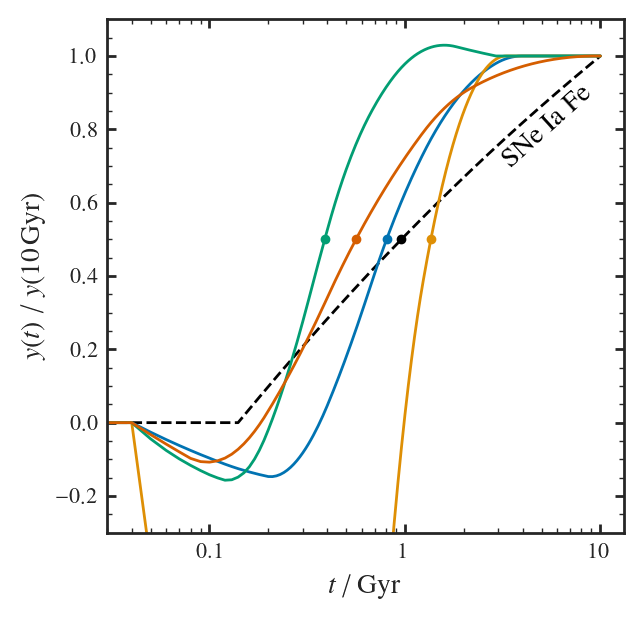

In [10]:
plt.figure(figsize=(10/3, 10/3))

vice.yields.ccsne.settings["c"] = 0
vice.yields.sneia.settings["c"] = 0
vice.yields.ccsne.settings["fe"] = 0

for i in range(4):
    model = AGB_MODELS[i]
    vice.yields.agb.settings["c"] = model
    m_c, times = vice.single_stellar_population("c", Z=0.014 * 10**0, dt=0.01)
    y = np.array(m_c)/m_c[-1]
    plt.plot(times, y)
    
    f = scipy.interpolate.interp1d(y, times)
    plt.scatter(f(0.5), 0.5)
    

plt.text(3, 0.7, "SNe Ia Fe", rotation=42, color="k")

m_fe, times = vice.single_stellar_population("fe", Z=0.014)
y = np.array(m_fe)/m_fe[-1]
plt.plot(times, y, 
         linestyle="--", zorder=-1, color="k")
f = scipy.interpolate.interp1d(y, times)
plt.scatter(f(0.5), 0.5, color="k")

vice.yields.ccsne.settings["n"] = 0
m_fe, times = vice.single_stellar_population("n", Z=0.014)
y = np.array(m_fe)/m_fe[-1]

#plt.plot(times, y, 
#         linestyle="--", zorder=-1, color="k")
f = scipy.interpolate.interp1d(y, times)
#plt.scatter(f(0.5), 0.5, color="k")


plt.xlabel(r"$t$ / Gyr")
plt.ylabel(r"$y(t)\;/\;y({10\, \rm Gyr})$")
plt.xscale("log")
plt.ylim(-0.3, 1.1)
plt.xlim(0.03, 13.2)
plt.xticks([0.1, 1, 10], labels=[0.1, 1, 10])

plt.savefig("figures/y_agb_vs_t.pdf")

# Linear Approximations

In [16]:
from scipy.integrate import quad
from scipy.interpolate import interp1d
from scipy.optimize import curve_fit

In [17]:
def lin(x, a, b):
    Z = MH_to_Z(x)
    return a + b*(Z-Z_SUN)

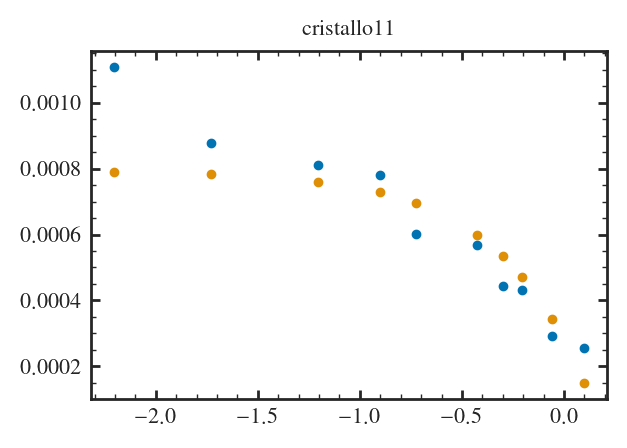

cristallo11
y0 = (2.784205 +- 0.477093) x 10^-4
zeta0 = (-3.211405 +- 0.440344) x 10^-2
y0 = 2.802412e-04



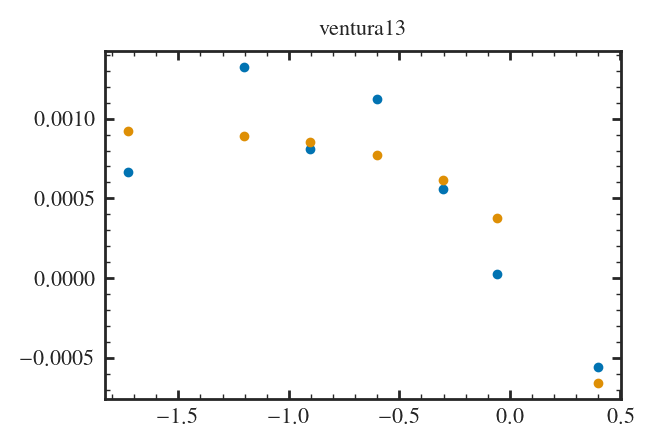

ventura13
y0 = (2.973105 +- 1.345255) x 10^-4
zeta0 = (-3.971588 +- 0.958942) x 10^-2
y0 = -2.089577e-05



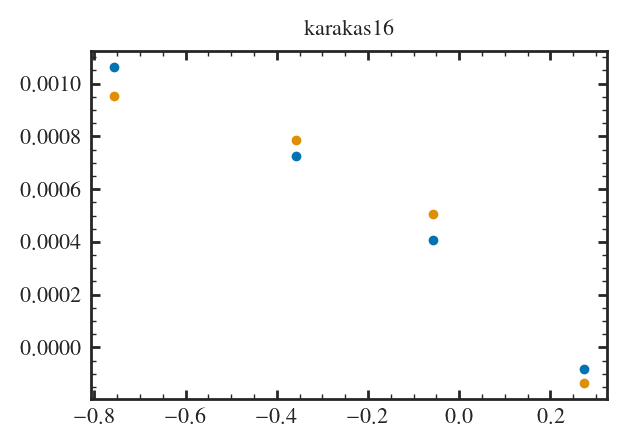

karakas16
y0 = (4.260433 +- 0.613903) x 10^-4
zeta0 = (-3.999737 +- 0.575453) x 10^-2
y0 = 3.444294e-04



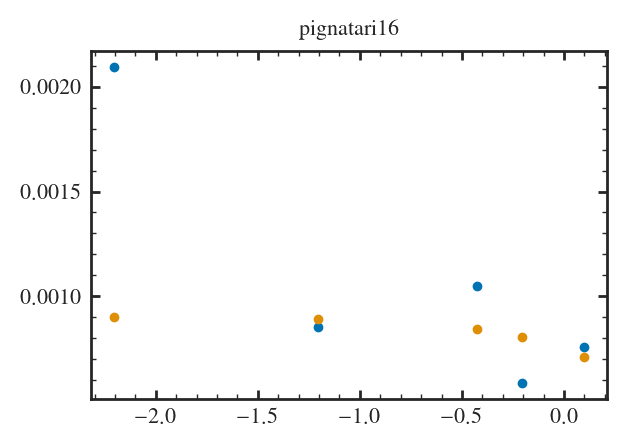

pignatari16
y0 = (7.460564 +- 1.508148) x 10^-4
zeta0 = (-0.960713 +- 1.553472) x 10^-2
y0 = 6.881450e-04



In [18]:
vice.yields.ccsne.settings["c"] = 0
for study in surp._globals.AGB_MODELS:
    y1, m1, z1 = vice.yields.agb.grid("c", study=study)
    mh1 = Z_to_MH(z1)
    vice.yields.agb.settings["c"] = vice.yields.agb.interpolator("c", study=study)
    y_c_agb1 = np.array([calc_y(z) for z in z1])

    plt.scatter(mh1, y_c_agb1)

    if study == "pignatari16":
        filt = mh1 > -1.5
    elif study == "cristallo11":
        filt = mh1 > -2
    else:
        filt = mh1 > - 1
    popt, covt = curve_fit(lin, mh1[filt], y_c_agb1[filt])

    plt.scatter(mh1, lin(mh1, *popt))
    plt.title(study)
    plt.show()

    
    print(study)
    errs = np.diag(np.sqrt(covt))
    print(f"y0 = ({popt[0]*1e4:3f} +- {errs[0]*1e4:3f}) x 10^-4")
    print(f"zeta0 = ({popt[1]*1e2:3f} +- {errs[1]*1e2:3f}) x 10^-2")

    print(f"y0 = {calc_y():3e}")
    print()
    

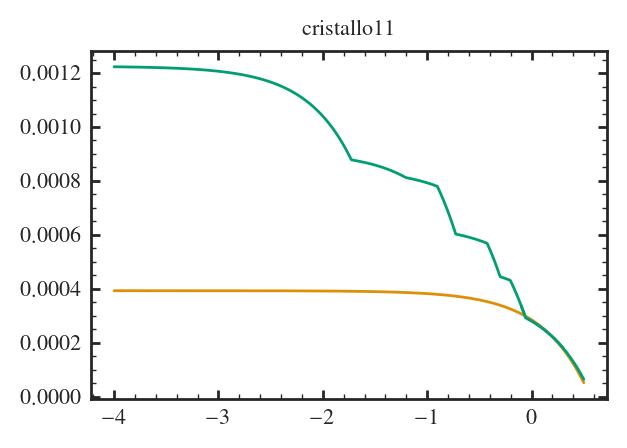

cristallo11
0.0002802412300328159
y0 = (2.846452 +- 0.002572) x 10^-4
zeta0 = (-0.674985 +- 0.003497) x 10^-2
alpha = (2.002493 +- 0.001809)




/tmp/slurmtmp.25958191/ipykernel_87541/4283509676.py:25: RuntimeWarning: invalid value encountered in sqrt
  errs = np.diag(np.sqrt(covt))


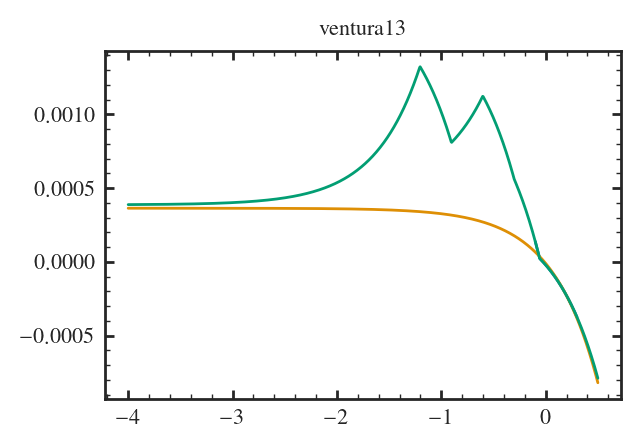

ventura13
-2.0895769414522992e-05
y0 = (-0.104670 +- 0.006090) x 10^-4
zeta0 = (-2.340068 +- 0.008282) x 10^-2
alpha = (-54.457037 +- 3.168279)




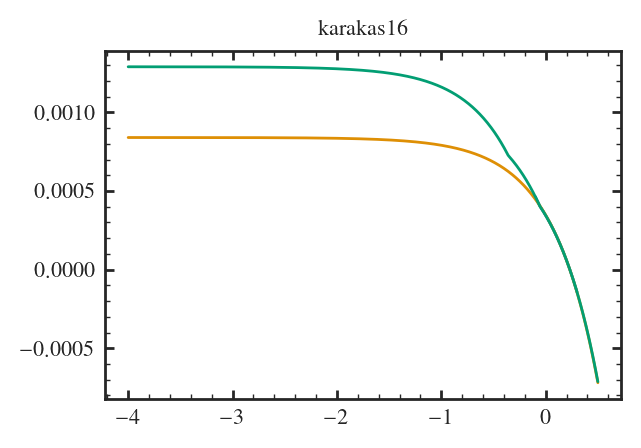

karakas16
0.0003444293792280909
y0 = (3.467910 +- 0.001379) x 10^-4
zeta0 = (-3.081520 +- 0.001876) x 10^-2
alpha = (1.643641 +- 0.000654)




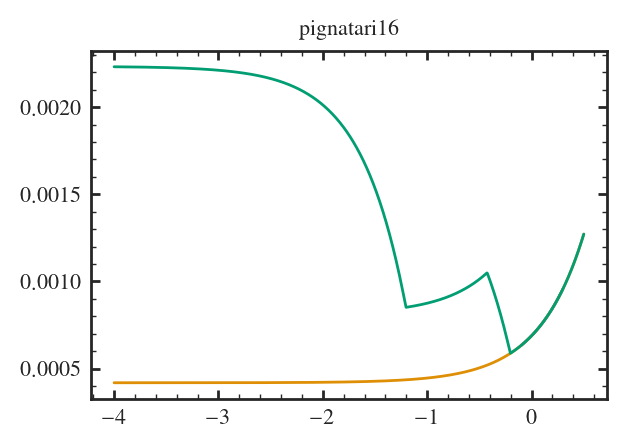

pignatari16
0.0006881450484335762
y0 = (6.881450 +- 0.000000) x 10^-4
zeta0 = (1.686494 +- 0.000000) x 10^-2
alpha = (0.828314 +- 0.000000)




In [14]:
for study in surp._globals.AGB_MODELS:
    Zs = Z_SUN*np.logspace(-0.1, 0.3, 1000)
    MH = Z_to_MH(Zs)

    vice.yields.agb.settings["c"] = vice.yields.agb.interpolator("c", study=study)
    vice.yields.ccsne.settings["c"] = 0
    vice.yields.sneia.settings["c"] = 0


    p, y_agb_mod = plot_y_z(Zs, label=study)
    popt, covt = curve_fit(lin, MH, y_agb_mod, p0 = (1e-4, 0.01))

    Zs = Z_SUN*np.logspace(-4, 0.5, 1000)
    MH = Z_to_MH(Zs)
    plt.plot(MH, lin(MH, *popt))
    plot_y_z(Zs, label=study)
    plt.title(study)
 
    plt.show()

    
    print(study)
    print(calc_y())

    errs = np.diag(np.sqrt(covt))
    print(f"y0 = ({popt[0]*1e4:3f} +- {errs[0]*1e4:3f}) x 10^-4")
    print(f"zeta0 = ({popt[1]*1e2:3f} +- {errs[1]*1e2:3f}) x 10^-2")
    alpha = surp.yields.Y_C_0 * 0.2 / popt[0]
    alpha_err = alpha * errs[0]/popt[0]

    
    print(f"alpha = ({alpha:3f} +- {alpha_err:3f})")
    print()
    print()
    

# Interpolation

In [14]:
from scipy.interpolate import CubicSpline
y1, m1, z1 = vice.yields.agb.grid("c")

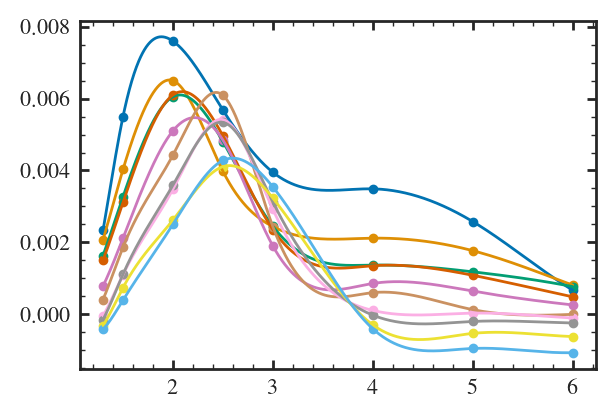

In [15]:
for i in range(len(z1)):
    
    def m_model(m):
        cs = CubicSpline([1] + list(m1) + [7], [0] + [a[i] for a in y1] + [0])
        return cs(m) * ( (m > 1) & (m < 7))
        
    x = np.linspace(1.3, 6, 1000)
    y =m_model(x)
    plt.plot(x, y)
    plt.scatter(m1, [a[i] for a in y1])

In [16]:
y_c_agb1 = []
for i in range(len(z1)):
    def m_model(m):
        cs = interp1d([1] + list(m1) + [7], [0] + [a[i] for a in y1] + [0])
        return cs(m) * ( (m > 1.3) & (m < 6))
    norm = quad(lambda m: m*vice.imf.kroupa(m), 0.08, 120)[0]
    yc = quad(lambda m: m*m_model(m)* vice.imf.kroupa(m), 1.3, 6)[0]/norm
    y_c_agb1.append(yc)

[-0.00031826  0.00042053]
[2.56664095e-05 2.58029025e-05]


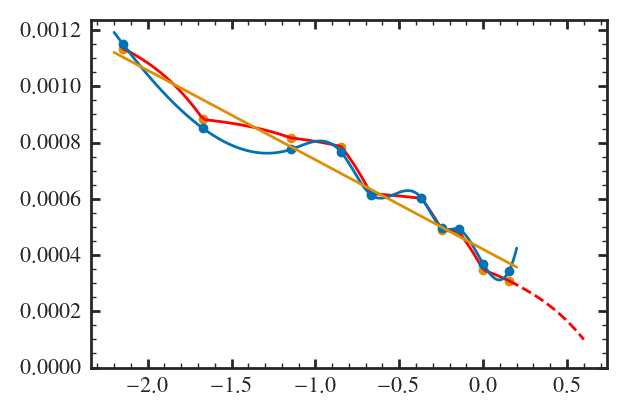

In [17]:
mh1 = np.log10(np.array(z1)/0.014)

cs = CubicSpline(mh1, y_c_agb1)

plt.scatter(mh1, y_c_agb1)

def yc_agb(z):
    return cs(z)
x = np.linspace(-2.2, 0.2, 1000)

def lin(x, a, b):
    return a*x + b

popt, covt = curve_fit(lin, mh1, y_c_agb1)
plt.plot(x, yc_agb(x))
plt.plot(x, lin(x, *popt))
plt.ylim(0)
print(popt)
print(np.diag(covt)**0.5)





vice.yields.agb.settings["c"] = "cristallo11"
vice.yields.ccsne.settings["c"] = 0
Zs = 0.014*10**np.linspace(-2, 1, 100)
model = "cristallo11"
    
    # plots importaint points
y1, m1, z1 = vice.yields.agb.grid('c', study=model)
Zs = np.array(z1)
mass_yields = []
for Z in Zs:
    m_c, times = vice.single_stellar_population("c", Z=Z)
    mass_yields.append(m_c[-1])
        
y_c_agb = np.array(mass_yields)/1e6 
y_o_cc = 0.015
plt.scatter(np.log10(Zs/0.014), y_c_agb, zorder=4-i)
    
    
MoverH_min = np.log10(min(Zs)/0.014)
MoverH_max = np.log10(max(Zs)/0.014)
    
Zs = 0.014*10**np.linspace(MoverH_min, MoverH_max, 100)
mass_yields = []
for Z in Zs:
    m_c, times = vice.single_stellar_population("c", Z=Z)
    mass_yields.append(m_c[-1])

l, = plt.plot(np.log10(Zs/0.014), (np.array(mass_yields)/1e6 ), 
              zorder=4-i, color="red")

Zs = 0.014*10**np.linspace(-2.1, MoverH_min, 100)
mass_yields = []
for Z in Zs:
    m_c, times = vice.single_stellar_population("c", Z=Z)
    mass_yields.append(m_c[-1])
plt.plot(np.log10(Zs/0.014), (np.array(mass_yields)/1e6 ), linestyle="--", 
          color=l.get_color(),  zorder=4-i)

Zs = 0.014*10**np.linspace(MoverH_max, 0.6, 100)
mass_yields = []
for Z in Zs:
    m_c, times = vice.single_stellar_population("c", Z=Z)
    mass_yields.append(m_c[-1])
plt.plot(np.log10(Zs/0.014), (np.array(mass_yields)/1e6 ), linestyle="--", 
          color=l.get_color(), zorder=4-i)

In [18]:
def calc_y_c_cc(y_agb_a, y_o_cc=0.015):
    y_c_cc =y_o_cc*gcem.brak_to_abund(c_o[filt], "C", "O") - y_agb_a[filt]
    y_c_cc_err = y_c_cc * c_o_err[filt] * np.log(10)
    return y_c_cc, y_c_cc_err

# Extra

NameError: name 'a_agb' is not defined

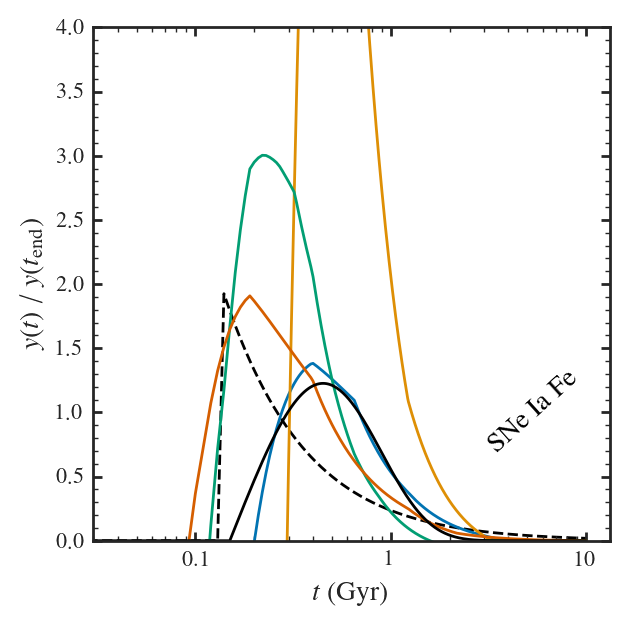

In [15]:
plt.figure(figsize=(10/3, 10/3))

vice.yields.ccsne.settings["c"] = 0
vice.yields.sneia.settings["c"] = 0
vice.yields.ccsne.settings["fe"] = 0

for i in range(4):
    model = AGB_MODELS[i]
    vice.yields.agb.settings["c"] = model
    m_c, times = vice.single_stellar_population("c", Z=0.014 * 10**0, dt=0.01)
    y = np.array(m_c)/m_c[-1]
    dt = times[1] - times[0]
    plt.plot(times[:-1], (y[1:] - y[:-1])/dt)
        

plt.text(3, 0.7, "SNe Ia Fe", rotation=42, color="k")

m_fe, times = vice.single_stellar_population("fe", Z=0.014)
y = np.array(m_fe)/m_fe[-1]
plt.plot(times[:-1], (y[1:] - y[:-1])/dt, 
         linestyle="--", zorder=-1, color="k")



plt.xlabel(r"$t$ (Gyr)")
plt.ylabel(r"$y(t)\;/\;y(t_{\rm end})$")
plt.xscale("log")
plt.xlim(0.03, 13.2)
plt.ylim(0, 4)
plt.xticks([0.1, 1, 10], labels=[0.1, 1, 10])
x = np.array(times)

t_d = 0.15
τa = 0.3
plt.plot(times, (x > t_d) * (x-t_d)/τa**2* np.exp(-(x-t_d)/τa), color="k")

vice.yields.agb.settings["c"] = a_agb
m_c, times = vice.single_stellar_population("c", Z=0.014 * 10**0, dt=0.01)
y = np.array(m_c)/m_c[-1]
dt = times[1] - times[0]
plt.plot(times[:-1], (y[1:] - y[:-1])/dt)


In [ ]:
surp.yields.set_yields(mass_factor=1.5)
y_agb = vice.yields.agb.settings["c"]

for Z in MH_to_Z(np.linspace(-3, 0.5, 5)):
    N = 100
    Ms = np.linspace(1, 7, N)
    ys = np.zeros(N)
    
    for i in range(N):
        ys[i] = y_agb(Ms[i], Z)
    
    plt.plot(Ms, ys, color=hmap(Z_to_MH(Z)))

yields set to Magg et al. 2022 abundances
Yield settings
X        Z_solar    CC                             agb                            SN Ia                          

c        3.39e-03   2.28e-03 + 9.61e-02 (Z - Z0)   1.68 × karakas16               0                              

n        1.04e-03   5.00e-04                       5.02e-04 M Z/Z0                0                              

o        7.33e-03   7.13e-03                       0                              0                              

mg       6.71e-04   6.52e-04                       0                              0                              

fe       1.37e-03   4.73e-04                       0                              7.70e-04                       



total c yield
agb_model:  karakas16
0.002850 + 0.029000 (Z-Zo)
f_agb = 0.2000




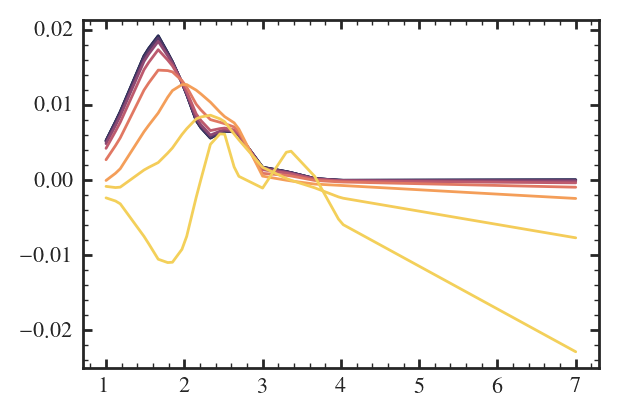

In [20]:
surp.yields.set_yields(agb_model="karakas16", mass_factor=1.5)
y_agb = vice.yields.agb.settings["c"]

for Z in MH_to_Z(np.linspace(-3, 0.5, 10)):
    N = 100
    Ms = np.linspace(1, 7, N)
    ys = np.zeros(N)
    
    for i in range(N):
        ys[i] = y_agb(Ms[i], Z)
    
    plt.plot(Ms, ys, color=hmap(Z_to_MH(Z)))

yields set to Magg et al. 2022 abundances
Yield settings
X        Z_solar    CC                             agb                            SN Ia                          

c        3.39e-03   2.28e-03 + 1.38e-01 (Z - Z0)   2.71 × ventura13               0                              

n        1.04e-03   5.00e-04                       5.02e-04 M Z/Z0                0                              

o        7.33e-03   7.13e-03                       0                              0                              

mg       6.71e-04   6.52e-04                       0                              0                              

fe       1.37e-03   4.73e-04                       0                              7.70e-04                       



total c yield
agb_model:  ventura13
0.002850 + 0.029000 (Z-Zo)
f_agb = 0.2000




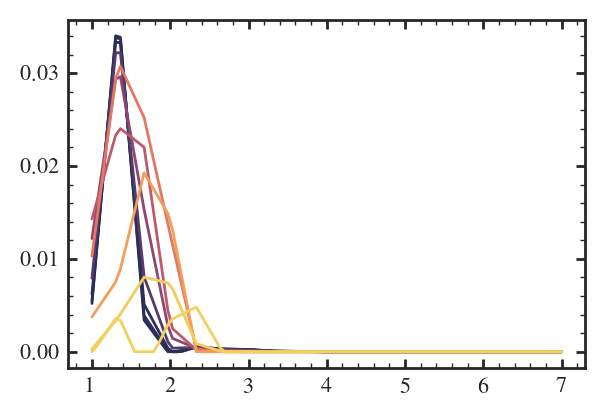

In [21]:
surp.yields.set_yields(agb_model="ventura13", mass_factor=1.5, no_negative=True)
y_agb = vice.yields.agb.settings["c"]

for Z in MH_to_Z(np.linspace(-3, 0.5, 10)):
    N = 100
    Ms = np.linspace(1, 7, N)
    ys = np.zeros(N)
    
    for i in range(N):
        ys[i] = y_agb(Ms[i], Z)
    
    plt.plot(Ms, ys, color=hmap(Z_to_MH(Z)))

In [22]:

def plot_n_table(study = "cristallo11", ax=None, fig=None, factor=1e2, **kwargs):
    if ax is None:
        fig, ax = plt.subplots()

    y1, m1, z1 = vice.yields.agb.grid('n', study=study)
    N = len(z1)

    for i in range(N):
        y = np.array(y1)[:,i] * factor
        z = z1[i] 
        c = hmap(np.log10(z/0.014))
        f = ax.plot(m1, y, "o", label=f"Z = {z}", c=(c), **kwargs)
        f = ax.plot(m1, y, label=f"Z = {z}", c=(c), **kwargs)
        # ax.set_xticks(np.arange(1, 8))
    
    ax.axhline(0, color="k", ls=":", zorder=-1)

    return f

In [ ]:
plot_n_table("pignatari16")
arya.Colorbar(huemap=hmap, label=r"Metallicity ($\log Z/Z_\odot$)")
plt.xlabel("M/Msun")
plt.ylabel("$y_{\rm N}$ --- Ritter et al. 2018")

In [ ]:
vice.yields.ccsne.settings["c"] = 0
vice.yields.sneia.settings["c"] = 0
vice.yields.ccsne.settings["fe"] = 0
cmap = arya.style.get_cmap()



model = "cristallo11"
mpp = arya.figure.colorbar.HueMap([-4, 1])


for model in ["cristallo11", "karakas10", "ventura13", "karakas16"]:
    _, _, z1 = vice.yields.agb.grid("c", model)
    plt.title(model)

    plt.xscale("log")
    cmap = arya.style.get_cmap()
    for i in range(len(z1)):
        z = z1[i]
        vice.yields.agb.settings["c"] = model
        m_c, times = vice.single_stellar_population("c", Z=z, dt=1e-3)
        m_c = [c for c in m_c]
        print(z)

        plt.plot(times, np.array(m_c)/1e6, color=ma(np.log10(z/0.014)))



    arya.Colorbar(huemap=mpp)
    plt.show()

In [ ]:
vice.yields.ccsne.settings["c"] = 0
vice.yields.sneia.settings["c"] = 0
vice.yields.ccsne.settings["fe"] = 0

model = "cristallo11"
mpp = arya.figure.colorbar.HueMap([-4, 1])

for model in ["cristallo11", "karakas10", "ventura13", "karakas16"]:
    _, _, z1 = vice.yields.agb.grid("c", model)

    plt.title(model)

    plt.xscale("log")
    cmap = arya.style.get_cmap()
    for i in range(len(z1)):
        z = z1[i]
        vice.yields.agb.settings["c"] = model
        m_c, times = vice.single_stellar_population("c", Z=z, dt=1e-3)
        m_c = [c for c in m_c]
        print(z)

        plt.plot(times, np.array(m_c)/m_c[-1], color=ma(np.log10(z/0.014)))



    arya.Colorbar(huemap=mpp)
    plt.show()